# Creating synthetic solar wind maps
***

In studies of more theoretical nature, it is of interest to construct a synthetic or idealized solar wind configuration. This example shows how this can be achieved. 

The standard EUHFORIA solar wind model requires the number density, temperature, radial speed and radial magnetic field to be given in as a input data file. The rest of the quantities are computed by the model using certain assumptions, e.g. $v_\theta = B_\theta = 0$. See the paper (or code) for details.

First, import all necessary libraries

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import datetime

In [2]:
%matplotlib inline

In [3]:
import euhforia
import euhforia.core.map
import euhforia.plot.synoptic
import euhforia.plot.colormap

import euhforia.core.constants as constants

from euhforia.heliosphere.mhd.solar_wind_boundary_data import *

To begin with, we need a function that saves given maps into the format read by the heliospheric model. This function is a very similar to the `save_heliospheric_boundary_to_ascii()` method of `euhforia.corona.empirical.EmpiricalCoronalModel`. 

In [7]:
def save_boundary_maps_to_ascii(file_name, boundary_data_maps):
    
    # Take date from one of the maps
    date = boundary_data_maps["vr"].meta['date']

    if isinstance(date, datetime.datetime):
        date = date.isoformat()

    fp = open(file_name, 'w')

    #
    # Write time
    #
    fp.write("Time:\n")
    fp.write(date + "\n")

    #
    # Write coordinates
    #

    fp.write("Radius of sphere:\n")
    fp.write(str(0.1*constants.astronomical_unit)+"\n")

    lons, lats = euhforia.core.map.get_center_coordinates(boundary_data_maps["vr"])
    
    lons_wrap = euhforia.core.map.get_ascending_longitudinal_coordinates(lons)
    
    clts = (0.5*np.pi-lats*np.pi/180.0)[::-1]

    fp.write("Number of colatitude grid points:\n")
    fp.write(str(len(clts))+"\n")
    fp.write("Colatitude grid points:\n")
    np.savetxt(fp, clts)

    fp.write("Number of longitude grid points:\n")
    fp.write(str(len(lons_wrap))+"\n")
    fp.write("Longitude grid points:\n")
    np.savetxt(fp, lons_wrap*np.pi/180.0)

    #
    # Write variables
    #
    #
    # Save in order: (lon_0, colat_0)
    #                (lon_0, colat_1) etc.

    for key in boundary_data_maps.keys():
        fp.write(str(key)+"\n")
        np.savetxt(fp, np.flipud(boundary_data_maps[key].data).flatten('F'))

    fp.close()

# Creating a uniform solar wind speed map

A date needs to be specified although for synthetic data this perhaps does not make much sense. One way of choosing the date is to select a time period where the spacecraft (e.g. Stereos) were at reasonable locations.

In [8]:
date = datetime.datetime(2015, 6, 25, 1, 4) # Random date...

In addition, the resolution of the map, and the coordinate system needs to be set. The heliosphere model requires the map to be in Stonyhurst (HEEQ) coordinates.

In [9]:
deg_per_pixel = 2.0
crval1 = 90.0 # Longitudinal coordinate of the map center 

The boundary data maps will be placed in a dict:

In [10]:
boundary_data = {}

Uniform solar wind radial speed at $r=0.1$ AU. All quantities should be in SI.

In [11]:
vr = 450e3

In [12]:
boundary_data["vr"] \
    = euhforia.core.map.create_empty_map(date=date, 
                                         deg_per_pixel=deg_per_pixel,
                                         crval1=crval1,
                                         ctype1="HGLN-CAR",
                                         ctype2="HGLT-CAR")
boundary_data["vr"].data[:, :] = vr

/Users/jpomoell/anaconda/lib/python2.7/site-packages/sunpy/time/time.py:178: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  if isinstance(time_string, pandas.tslib.Timestamp):


Number density. In the empirical model, number density is computed as $n = n_\mathrm{fsw} (v_\mathrm{fsw}/v_r)^2$. Let's use that here as well:

In [13]:
vfsw = 625.0e3
nfsw = 300.0e6

n = nfsw*(vfsw/vr)**2

print(n/1e8, "* 10^8 1/m^3")

5.78703703704 * 10^8 1/m^3


In [14]:
boundary_data["number_density"] \
    = euhforia.core.map.create_empty_map(date=date, 
                                         deg_per_pixel=deg_per_pixel,
                                         crval1=crval1,
                                         ctype1="HGLN-CAR",
                                         ctype2="HGLT-CAR")
boundary_data["number_density"].data[:, :] = n

Temperature is computed using the ideal gas law $P = n k_\mathrm{B} T$ where the pressure is assumed to be constant.

In [15]:
P = 3.3e-9
T = P/(n*constants.kB)

print(T/1e6, "MK")

0.413023294299 MK


In [16]:
boundary_data["temperature"] \
    = euhforia.core.map.create_empty_map(date=date, 
                                         deg_per_pixel=deg_per_pixel,
                                         crval1=crval1,
                                         ctype1="HGLN-CAR",
                                         ctype2="HGLT-CAR")
boundary_data["temperature"].data[:, :] = T

The radial magnetic field needs also to be specified

In [17]:
boundary_data["Br"] \
    = euhforia.core.map.create_empty_map(date=date, 
                                         deg_per_pixel=deg_per_pixel,
                                         crval1=crval1,
                                         ctype1="HGLN-CAR",
                                         ctype2="HGLT-CAR")

Now the results can be plotted as usual, although the results don't look too exciting...

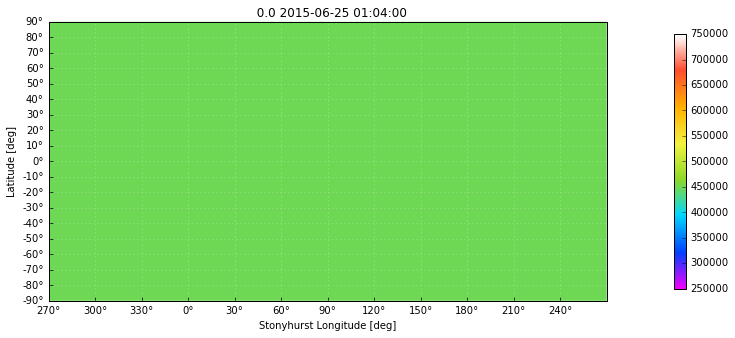

In [18]:
boundary_data["vr"].plot_settings["norm"] = plt.Normalize(250e3, 750e3)
boundary_data["vr"].plot_settings["cmap"] = euhforia.plot.colormap.citrus_low
euhforia.plot.synoptic.plot(boundary_data["vr"]);

Finally, the map can be saved

In [19]:
save_boundary_maps_to_ascii("uniform_wind_map.dat", boundary_data)

# Stream interaction map

As a second example, let's create a map that is slightly more exciting featuring a high speed stream embedded in an otherwise uniform wind

In [20]:
date = datetime.datetime(2008, 1, 5)

In [21]:
deg_per_pixel = 2.0
crval1 = 90.0 # Longitudinal coordinate of the map center 

In [22]:
boundary_data = {}

In [23]:
vfsw = 625.0e3
nfsw = 300.0e6
Bfsw = 300.0e-9

In [24]:
boundary_data["vr"] \
    = euhforia.core.map.create_empty_map(date=date, 
                                         deg_per_pixel=deg_per_pixel,
                                         crval1=crval1,
                                         ctype1="HGLN-CAR",
                                         ctype2="HGLT-CAR")

lons, lats = euhforia.core.map.get_center_coordinates(boundary_data["vr"])
lons_wrap = euhforia.core.map.get_ascending_longitudinal_coordinates(lons)

boundary_data["vr"].data[:, :] = 450.0e3

lon0 = 60.0
lat0 = 5.0
size = 20.0

for j, lat in enumerate(lats):
    for i, lon in enumerate(lons_wrap):

        if ((lon-lon0)**2 + (lat-lat0)**2 < size**2):        
            boundary_data["vr"].data[j, i] = vfsw

In [25]:
boundary_data["vr"].plot_settings["norm"] = plt.Normalize(250e3, 750e3)
boundary_data["vr"].plot_settings["cmap"] = euhforia.plot.colormap.citrus_low
euhforia.plot.synoptic.plot(boundary_data["vr"]);

Compute the remaining quantities similar as in the uniform wind example

In [26]:
n = nfsw*(vfsw/boundary_data["vr"].data)**2

In [27]:
boundary_data["number_density"] \
    = euhforia.core.map.create_empty_map(date=date, 
                                         deg_per_pixel=deg_per_pixel,
                                         crval1=crval1,
                                         ctype1="HGLN-CAR",
                                         ctype2="HGLT-CAR")
boundary_data["number_density"].data[:, :] = n

In [28]:
euhforia.plot.synoptic.plot(boundary_data["number_density"]);

In [29]:
P = 3.3e-9
T = P/(n*constants.kB)

In [30]:
boundary_data["temperature"] \
    = euhforia.core.map.create_empty_map(date=date, 
                                         deg_per_pixel=deg_per_pixel,
                                         crval1=crval1,
                                         ctype1="HGLN-CAR",
                                         ctype2="HGLT-CAR")
boundary_data["temperature"].data[:, :] = T

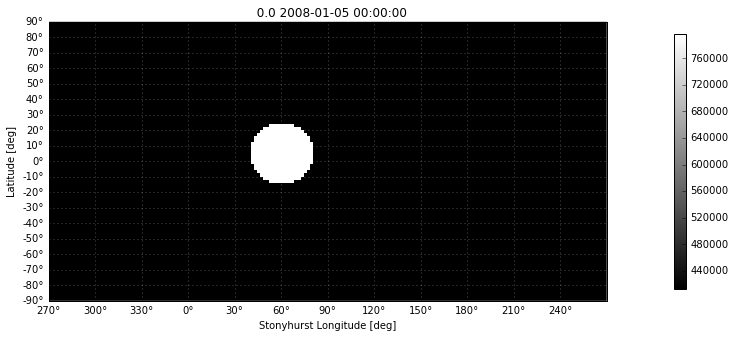

In [31]:
euhforia.plot.synoptic.plot(boundary_data["temperature"]);

In [32]:
boundary_data["Br"] \
    = euhforia.core.map.create_empty_map(date=date, 
                                         deg_per_pixel=deg_per_pixel,
                                         crval1=crval1,
                                         ctype1="HGLN-CAR",
                                         ctype2="HGLT-CAR")

In [33]:
lons, lats = euhforia.core.map.get_center_coordinates(boundary_data["vr"])

for j, lat in enumerate(lats):
    for i, lon in enumerate(lons_wrap):

        dlat = 70.0*np.sin((lon+30.0)*np.pi/180.0)
        
        Bsign = np.sign(np.sin((lat+dlat)*np.pi/180.0))
        
        boundary_data["Br"].data[j, i] = Bsign*Bfsw*(boundary_data["vr"].data[j, i]/vfsw)
        

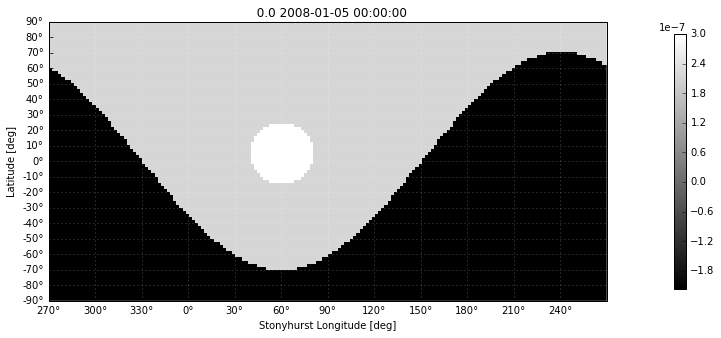

In [34]:
euhforia.plot.synoptic.plot(boundary_data["Br"]);

In [35]:
save_boundary_maps_to_ascii("cir_wind_map.dat", boundary_data)

***